In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
TARGET_FEATURE_NAME = "label"
TARGET_FEATURE_LABELS = ["0", "1"]
NUM_CLASSES = len(TARGET_FEATURE_LABELS)

# Numeric Feature
NUMERIC_FEATURE_NAMES = [
    'movieAvgRating',
    'movieRatingStddev',
    'movieRatingCount',
    'userAvgRating',
    'userRatingStddev',
    'userRatingCount',
    'releaseYear',
]

# ID Feature
ID_FEATURE_NAMES = ['movieId', 'userId']

# Categorical Feature
genre_vocab = ['Film-Noir', 'Action', 'Adventure', 
               'Horror', 'Romance', 'War', 
               'Comedy', 'Western', 'Documentary',
               'Sci-Fi', 'Drama', 'Thriller',
               'Crime', 'Fantasy', 'Animation', 
               'IMAX', 'Mystery', 'Children', 'Musical']

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    'userGenre1': genre_vocab,
    'userGenre2': genre_vocab,
    'userGenre3': genre_vocab,
    'userGenre4': genre_vocab,
    'userGenre5': genre_vocab,
    'movieGenre1': genre_vocab,
    'movieGenre2': genre_vocab,
    'movieGenre3': genre_vocab
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES + ID_FEATURE_NAMES

# 读取CSV时的缺失值填充
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in FEATURE_NAMES
]

In [6]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        if feature_name in ID_FEATURE_NAMES:
            inputs[feature_name] = keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [7]:
def encode_WD_inputs(inputs, embedding_dims=10):
    encoded_cols = []
    cat_cols = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            cat_col = tf.feature_column.categorical_column_with_hash_bucket(
                key=feature_name, hash_bucket_size=10)
            emb_col = tf.feature_column.embedding_column(cat_col, embedding_dims)
            cat_cols.append(tf.feature_column.indicator_column(cat_col))
            
        elif feature_name in ID_FEATURE_NAMES:
            cat_col = tf.feature_column.categorical_column_with_hash_bucket(
                key=feature_name, hash_bucket_size=1000)
            emb_col = tf.feature_column.embedding_column(cat_col, embedding_dims)
            
        elif feature_name in NUMERIC_FEATURE_NAMES:
            emb_col = tf.feature_column.numeric_column(feature_name)
        encoded_cols.append(emb_col)
        
    return encoded_cols, cat_cols

In [8]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 12
num_epochs =3

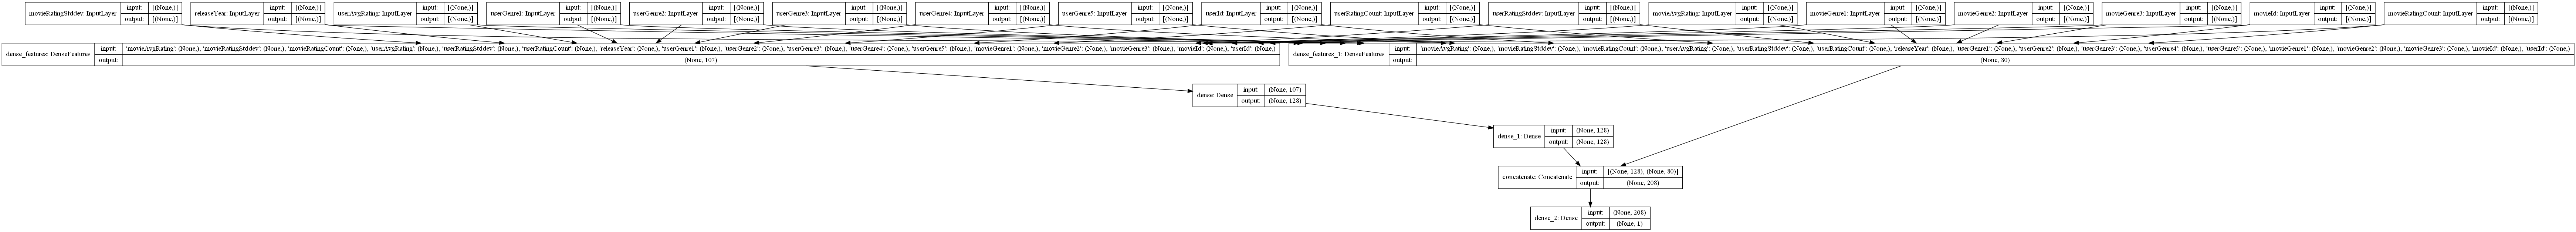

In [9]:
def create_WD_model():
    inputs = create_model_inputs()
    deep_feature, wide_feature = encode_WD_inputs(inputs)
    # deep part
    deep = tf.keras.layers.DenseFeatures(deep_feature)(inputs)
    deep = tf.keras.layers.Dense(128, activation='relu')(deep)
    deep = tf.keras.layers.Dense(128, activation='relu')(deep)
    # wide part
    wide = tf.keras.layers.DenseFeatures(wide_feature)(inputs)
    # output
    both = tf.keras.layers.concatenate([deep, wide])
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(both)
    model = tf.keras.Model(inputs, output_layer)
    return model
    
WD_model = create_WD_model()
keras.utils.plot_model(WD_model, show_shapes=True, rankdir="TB")

In [10]:
training_samples_file_path = './sampledata/trainingSamples.csv'
test_samples_file_path = './sampledata/testSamples.csv'

def get_dataset(file_path, batch_size):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=batch_size,
        label_name='label',
        na_value="0",
        num_epochs=1,
        ignore_errors=True)
    return dataset.cache()

batch_size = 128
# split as test dataset and training dataset
train_dataset = get_dataset(training_samples_file_path, batch_size)
test_dataset = get_dataset(test_samples_file_path, batch_size)

In [11]:
def run_experiment(model): 

    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.AUC(curve='ROC'), tf.keras.metrics.AUC(curve='PR')],
    )
    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy, _, _ = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [13]:
run_experiment(WD_model)

Start training the model...
Epoch 1/3


D:\Conda\envs\studio\lib\site-packages\tensorflow\python\keras\engine\functional.py:595: UserWarning: Input dict contained keys ['rating', 'timestamp', 'userRatedMovie1', 'userRatedMovie2', 'userRatedMovie3', 'userRatedMovie4', 'userRatedMovie5', 'userAvgReleaseYear', 'userReleaseYearStddev'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


694/694 [==============================] - 7s 5ms/step - loss: 9.6514 - accuracy: 0.5370 - auc: 0.5398 - auc_1: 0.5963
Epoch 2/3
694/694 [==============================] - 4s 6ms/step - loss: 3.2797 - accuracy: 0.5678 - auc: 0.5812 - auc_1: 0.6318
Epoch 3/3
694/694 [==============================] - 3s 5ms/step - loss: 2.3546 - accuracy: 0.5904 - auc: 0.6101 - auc_1: 0.6561
Model training finished
Test accuracy: 66.31%
